Number of trips: 146
Harsh braking ratio: 0.397


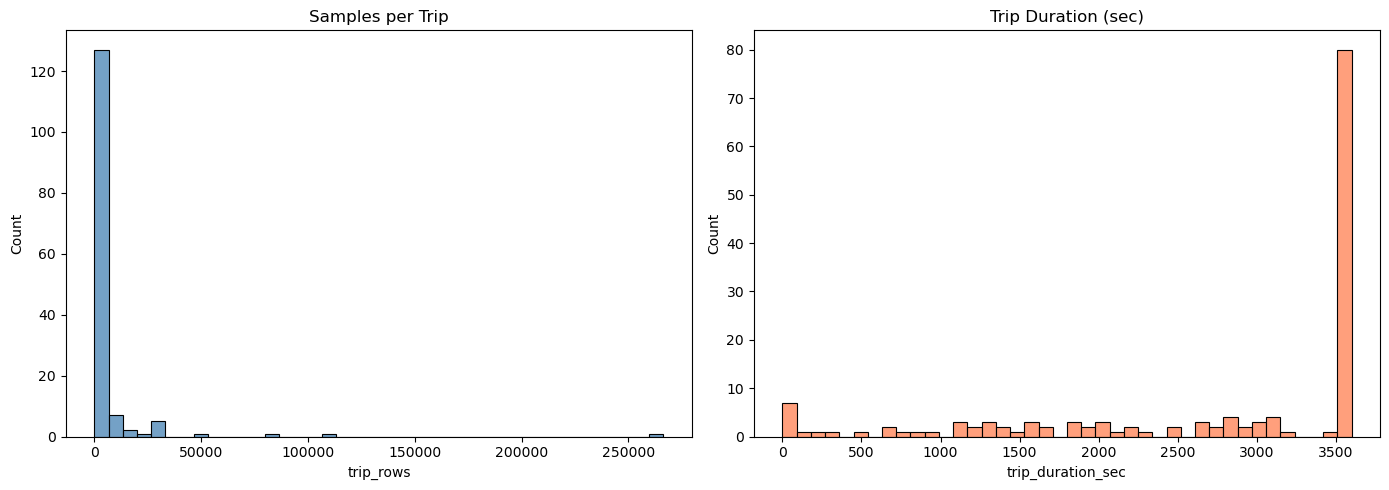

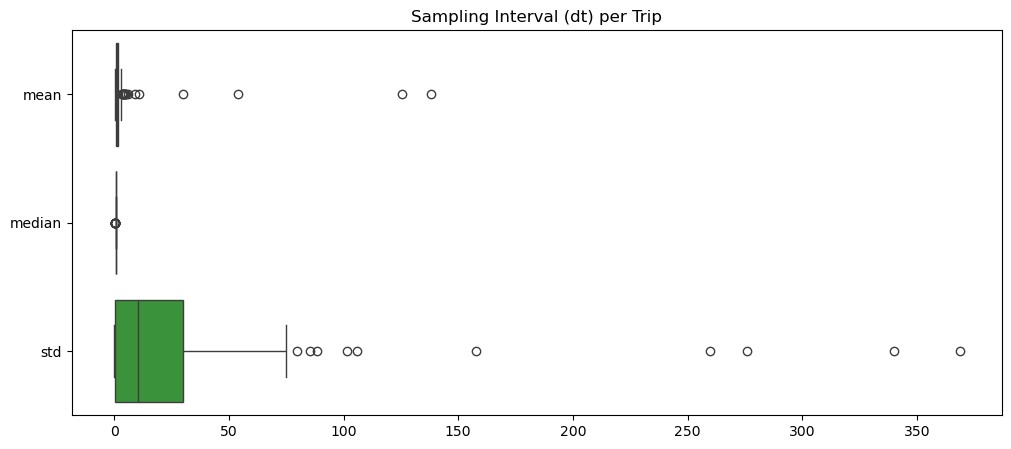

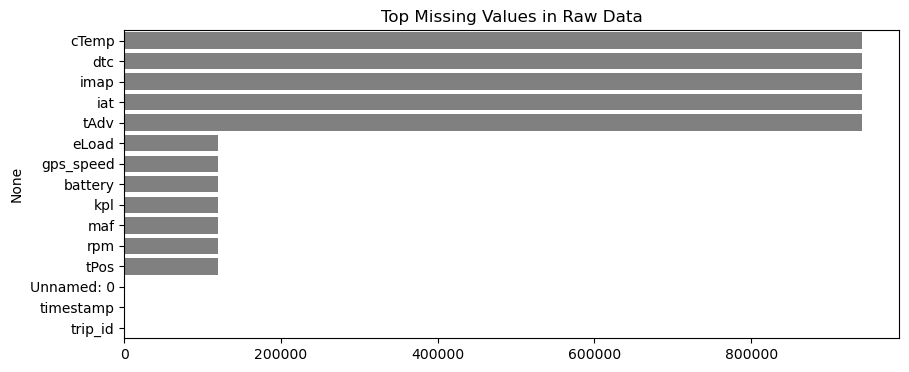

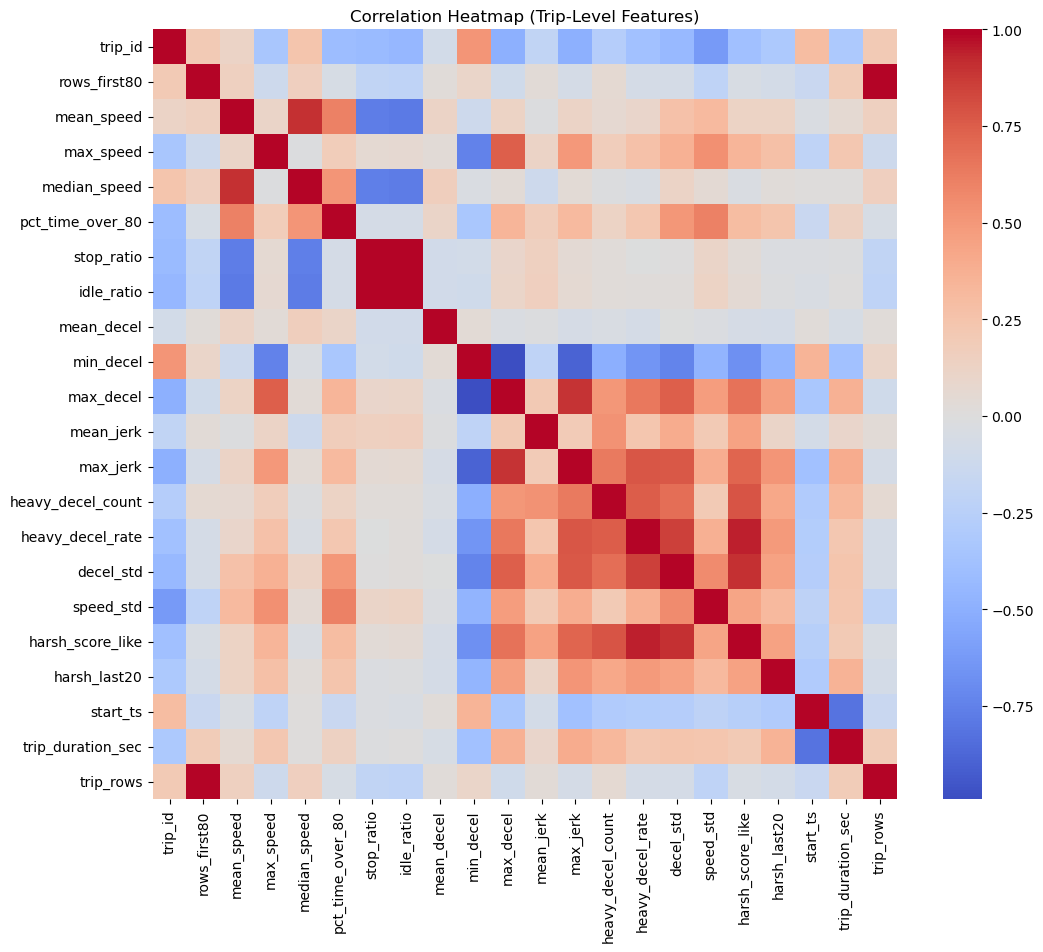

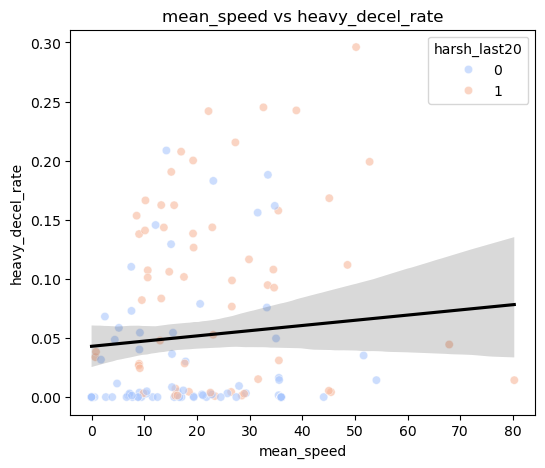

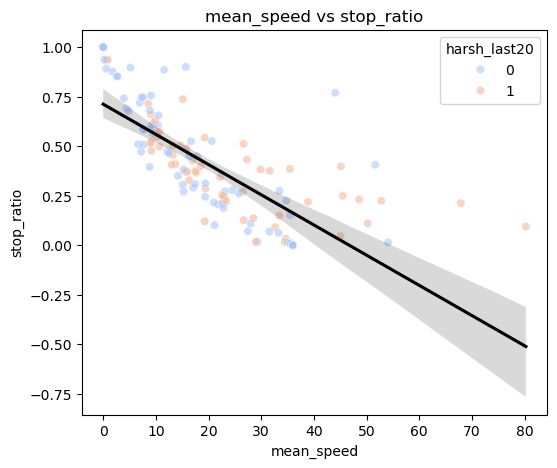

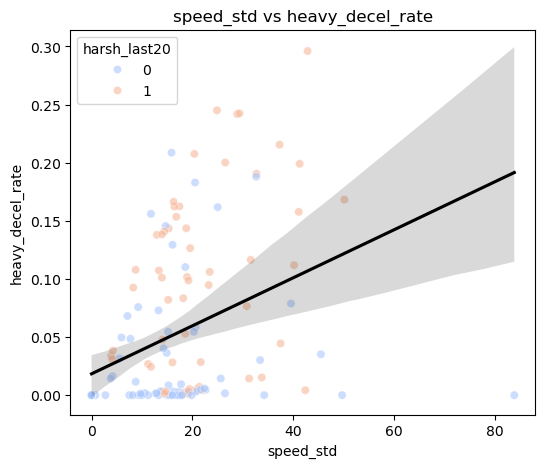


Correlations among chosen pairs:
mean_speed ↔ heavy_decel_rate: 0.091
mean_speed ↔ stop_ratio: -0.768
speed_std ↔ heavy_decel_rate: 0.374


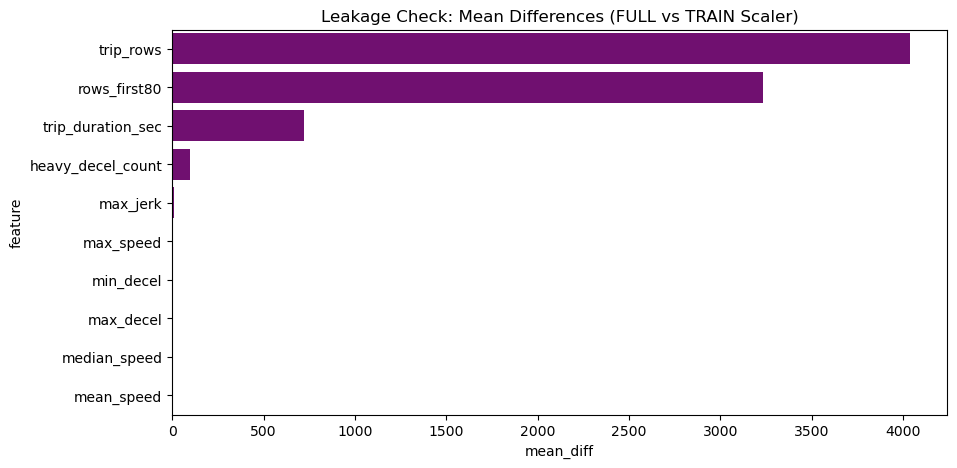

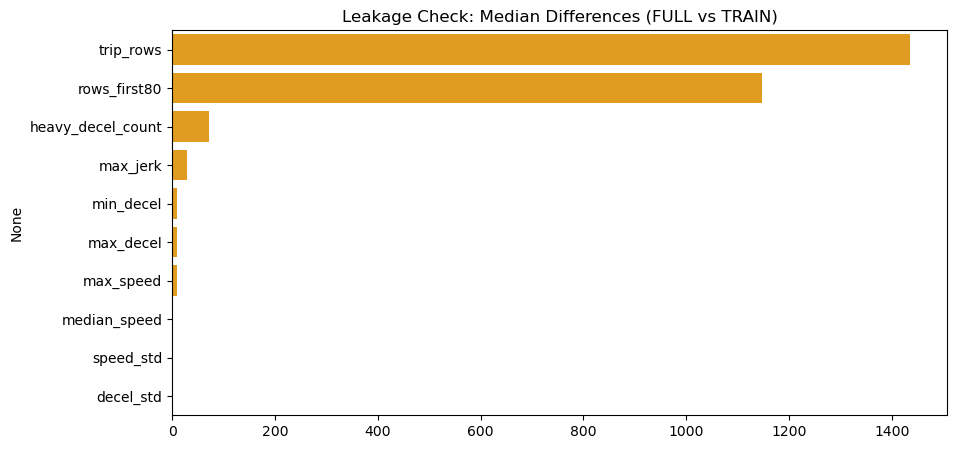


RandomForest F1: 0.4444444444444444
              precision    recall  f1-score   support

           0       0.96      0.85      0.90        27
           1       0.33      0.67      0.44         3

    accuracy                           0.83        30
   macro avg       0.65      0.76      0.67        30
weighted avg       0.90      0.83      0.86        30

✅ Saved: trip_level_features_labels_dashboard.csv and dt_summary_per_trip.csv


In [1]:
# ===============================================================
# 🚗 Full Trip-Level Feature Pipeline + Statistical Dashboard + Leakage Analysis
# ===============================================================

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# ---------------------------------------------------------------
# 1️⃣ LOAD & CLEAN RAW DATA
# ---------------------------------------------------------------
path = r'C:/Users/Asus/Downloads/allcars.csv'  # <-- change if needed
df = pd.read_csv(path)
df.columns = [c.strip() for c in df.columns]

if 'timeStamp' in df.columns:
    df = df.rename(columns={'timeStamp': 'timestamp'})
if 'tripID' in df.columns:
    df = df.rename(columns={'tripID': 'trip_id'})

# timestamp → seconds
def parse_ts(s):
    try:
        parts = str(s).split(':')
        if len(parts)==2:
            m = float(parts[0]); sec = float(parts[1])
            return m*60 + sec
        elif len(parts)==3:
            h, m, sec = map(float, parts)
            return h*3600 + m*60 + sec
        else:
            return float(s)
    except:
        return np.nan

df['ts_seconds'] = df['timestamp'].apply(parse_ts)

# ensure speed column
if 'speed' not in df.columns and 'gps_speed' in df.columns:
    df['speed'] = df['gps_speed']
if 'speed' not in df.columns:
    raise ValueError("No 'speed' column found in the dataset!")

# ---------------------------------------------------------------
# 2️⃣ DERIVATIVES & FEATURES
# ---------------------------------------------------------------
def compute_derivs(g):
    g = g.sort_values('ts_seconds').reset_index(drop=True)
    g['dt'] = g['ts_seconds'].diff().fillna(1.0)
    g.loc[g['dt'] <= 0, 'dt'] = 0.5
    g['speed_mps'] = g['speed'].fillna(0) * (1000/3600)
    g['dv'] = g['speed_mps'].diff().fillna(0)
    g['decel'] = (g['dv'] / g['dt']).clip(-50,50)
    g['jerk'] = g['decel'].diff().fillna(0) / g['dt']
    g['jerk'] = g['jerk'].clip(-100,100)
    return g

df = df.groupby('trip_id', group_keys=False).apply(compute_derivs)

# label = harsh braking in last 20%
def label_trip(g, thr=-3.0):
    g = g.sort_values('ts_seconds')
    n = len(g)
    cutoff = int(np.ceil(0.8*n))
    last = g.iloc[cutoff:]
    return int((last['decel'] <= thr).any())

trip_labels = df.groupby('trip_id').apply(label_trip).rename('harsh_last20').reset_index()

# feature aggregation (first 80%)
def agg_feats(g):
    g = g.sort_values('ts_seconds').reset_index(drop=True)
    n = len(g)
    cutoff = int(np.ceil(0.8*n))
    first = g.iloc[:cutoff]
    res = {
        'rows_first80': len(first),
        'mean_speed': first['speed'].mean(),
        'max_speed': first['speed'].max(),
        'median_speed': first['speed'].median(),
        'pct_time_over_80': (first['speed'] > 80).mean(),
        'stop_ratio': (first['speed'] <= 1).mean(),
        'idle_ratio': (first['speed'] < 5).mean(),
        'mean_decel': first['decel'].mean(),
        'min_decel': first['decel'].min(),
        'max_decel': first['decel'].max(),
        'mean_jerk': first['jerk'].mean(),
        'max_jerk': first['jerk'].max(),
        'heavy_decel_count': (first['decel'] <= -3.0).sum(),
    }
    res['heavy_decel_rate'] = res['heavy_decel_count'] / max(1, res['rows_first80'])
    res['decel_std'] = first['decel'].std()
    res['speed_std'] = first['speed'].std()
    res['harsh_score_like'] = -res['min_decel'] * res['heavy_decel_rate'] + abs(res['mean_jerk'] or 0)
    return pd.Series(res)

trip_feats = df.groupby('trip_id').apply(agg_feats).reset_index()
data = trip_feats.merge(trip_labels, on='trip_id', how='left')
data['start_ts'] = df.groupby('trip_id')['ts_seconds'].min().values
data['trip_duration_sec'] = df.groupby('trip_id')['ts_seconds'].apply(lambda x: x.max() - x.min()).values
data['trip_rows'] = df.groupby('trip_id').size().values

# clean NaN/inf
data.replace([np.inf, -np.inf], np.nan, inplace=True)
for c in data.columns:
    if data[c].dtype.kind in 'fi':
        data[c].fillna(data[c].median(), inplace=True)

# ---------------------------------------------------------------
# 3️⃣ BASIC STATS & VISUALIZATIONS (Dashboard)
# ---------------------------------------------------------------
print(f"Number of trips: {data['trip_id'].nunique()}")
print(f"Harsh braking ratio: {data['harsh_last20'].mean():.3f}")

# Trip granularity plots
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.histplot(data['trip_rows'], bins=40, color='steelblue')
plt.title('Samples per Trip')
plt.subplot(1,2,2)
sns.histplot(data['trip_duration_sec'], bins=40, color='coral')
plt.title('Trip Duration (sec)')
plt.tight_layout()
plt.show()

# Sampling interval visualization
dt_summary = df.groupby('trip_id')['dt'].agg(['count','mean','median','std']).reset_index()
plt.figure(figsize=(12,5))
sns.boxplot(data=dt_summary[['mean','median','std']], orient='h')
plt.title('Sampling Interval (dt) per Trip')
plt.show()

# Missing value plot
missing = df.isna().sum().sort_values(ascending=False)
plt.figure(figsize=(10,4))
sns.barplot(x=missing.head(15).values, y=missing.head(15).index, color='gray')
plt.title('Top Missing Values in Raw Data')
plt.show()

# Correlation heatmap (trip-level)
plt.figure(figsize=(12,10))
corr = data.select_dtypes('number').corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (Trip-Level Features)')
plt.show()

# ---------------------------------------------------------------
# 4️⃣ INSIGHTFUL RELATIONSHIPS
# ---------------------------------------------------------------
pairs = [
    ('mean_speed', 'heavy_decel_rate'),
    ('mean_speed', 'stop_ratio'),
    ('speed_std', 'heavy_decel_rate')
]
for a,b in pairs:
    plt.figure(figsize=(6,5))
    sns.scatterplot(x=data[a], y=data[b], hue=data['harsh_last20'], palette='coolwarm', alpha=0.6)
    sns.regplot(x=data[a], y=data[b], scatter=False, color='black')
    plt.title(f"{a} vs {b}")
    plt.show()

print("\nCorrelations among chosen pairs:")
for a,b in pairs:
    print(f"{a} ↔ {b}: {data[a].corr(data[b]):.3f}")

# ---------------------------------------------------------------
# 5️⃣ DATA LEAKAGE CHECK VISUALIZATION
# ---------------------------------------------------------------
features = [c for c in data.columns if c not in ['trip_id','harsh_last20','start_ts']]
data = data.sort_values('start_ts').reset_index(drop=True)
n = len(data); train_end=int(0.6*n); val_end=int(0.8*n)
train = data.iloc[:train_end]; val = data.iloc[train_end:val_end]; test = data.iloc[val_end:]
X_train, X_test = train[features], test[features]

# Full scaler vs train-only scaler
sc_full = StandardScaler().fit(data[features])
sc_train = StandardScaler().fit(X_train)

mean_diff = np.abs(sc_full.mean_ - sc_train.mean_)
std_diff = np.abs(sc_full.scale_ - sc_train.scale_)
diff_df = pd.DataFrame({'feature': features, 'mean_diff': mean_diff, 'std_diff': std_diff})
diff_df = diff_df.sort_values('mean_diff', ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x='mean_diff', y='feature', data=diff_df, color='purple')
plt.title('Leakage Check: Mean Differences (FULL vs TRAIN Scaler)')
plt.show()

# Median imputation check
med_full = data[features].median()
med_train = X_train.median()
med_diff = (med_full - med_train).abs().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=med_diff.values, y=med_diff.index, color='orange')
plt.title('Leakage Check: Median Differences (FULL vs TRAIN)')
plt.show()

# ---------------------------------------------------------------
# 6️⃣ MODELING (optional quick F1)
# ---------------------------------------------------------------
scaler = StandardScaler()
imp = SimpleImputer(strategy='median')

X_train_imp = imp.fit_transform(X_train)
X_test_imp = imp.transform(X_test)
X_train_sc = scaler.fit_transform(X_train_imp)
X_test_sc = scaler.transform(X_test_imp)
y_train, y_test = train['harsh_last20'], test['harsh_last20']

rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train_sc, y_train)
y_pred = rf.predict(X_test_sc)
print("\nRandomForest F1:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# ---------------------------------------------------------------
# 7️⃣ SAVE OUTPUTS
# ---------------------------------------------------------------
data.to_csv('trip_level_features_labels_dashboard.csv', index=False)
dt_summary.to_csv('dt_summary_per_trip.csv', index=False)
print("✅ Saved: trip_level_features_labels_dashboard.csv and dt_summary_per_trip.csv")


In [ ]:
%history -f carsvisual.py